<a href="https://colab.research.google.com/github/cpk110/ChatGPT/blob/master/005_kakaobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/ai_chatbot_python/ChatGPT/005'

Mounted at /content/drive
/content/drive/MyDrive/ai_chatbot_python/ChatGPT/005


### 1. FastAPI를 활용해서 로컬서버 생성하기

In [2]:
# 파이썬 기반의 웹 서버를 생성하기 위한 오픈소스
!pip install fastapi

# FastAPI 단독으로 웹개발을 할 수 없다.
# 따라서 비동기 서버를 생성하는 uvicorn을 추가로 설치한다.
!pip install 'uvicorn[standard]'

!pip install pyngrok
!pip install openai==0.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━

In [4]:
%%writefile kakaobot.py
from fastapi import Request, FastAPI

app = FastAPI()

@app.get("/")
async def root():
  return {"message" : "KakaoTest"}

@app.post('/chat/')
async def chat(request : Request):
  kakaorequest = await request.json()
  print(kakaorequest)
  return

Writing 005/kakaobot.py


### 2. ngrok으로 로컬서버 외부에서 접속 할 수 있도록 구현

In [8]:
# Ngrok은 외부(Public)에서 로컬에 접속 할 수 있게 도와주는 터널링 프로그램이다.
from pyngrok import ngrok

port = 8000
ngrok.set_auth_token('')
print(dir(ngrok.connect(port)))
public_url = ngrok.connect(port).public_url
print('click', public_url)

# !uvicorn /content/drive/MyDrive/ai_chatbot_python/ChatGPT/005/kakaobot:app --reload --server.port=800  # --server.port=8000는 붙여서 적어야함
!uvicorn kakaobot:app --reload

# 계속 돌아가는 상태에서 진행

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'api_url', 'config', 'data', 'id', 'metrics', 'name', 'proto', 'public_url', 'pyngrok_config', 'refresh_metrics', 'uri']
click https://64c9-34-74-99-26.ngrok-free.app
INFO:     Will watch for changes in these directories: ['/content/drive/MyDrive/ai_chatbot_python/ChatGPT/005']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [14653] using WatchFiles
INFO:     Started server process [14667]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:    

### 3. 채널생성 & 챗봇생성 (카카오톡)

스킬 → 시나리오 → 설정 → 배포

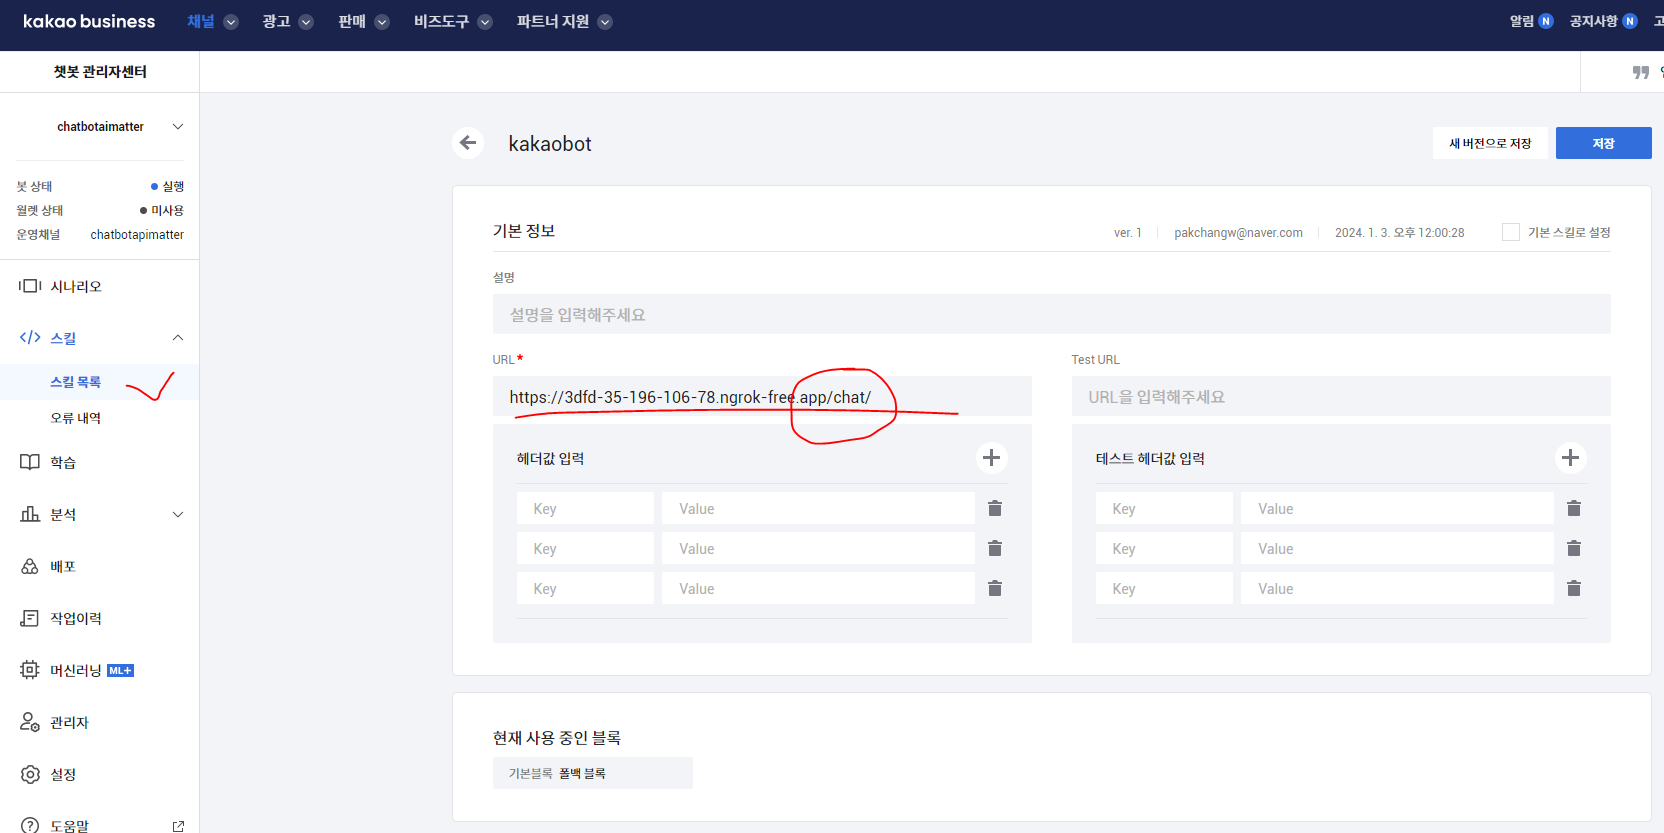

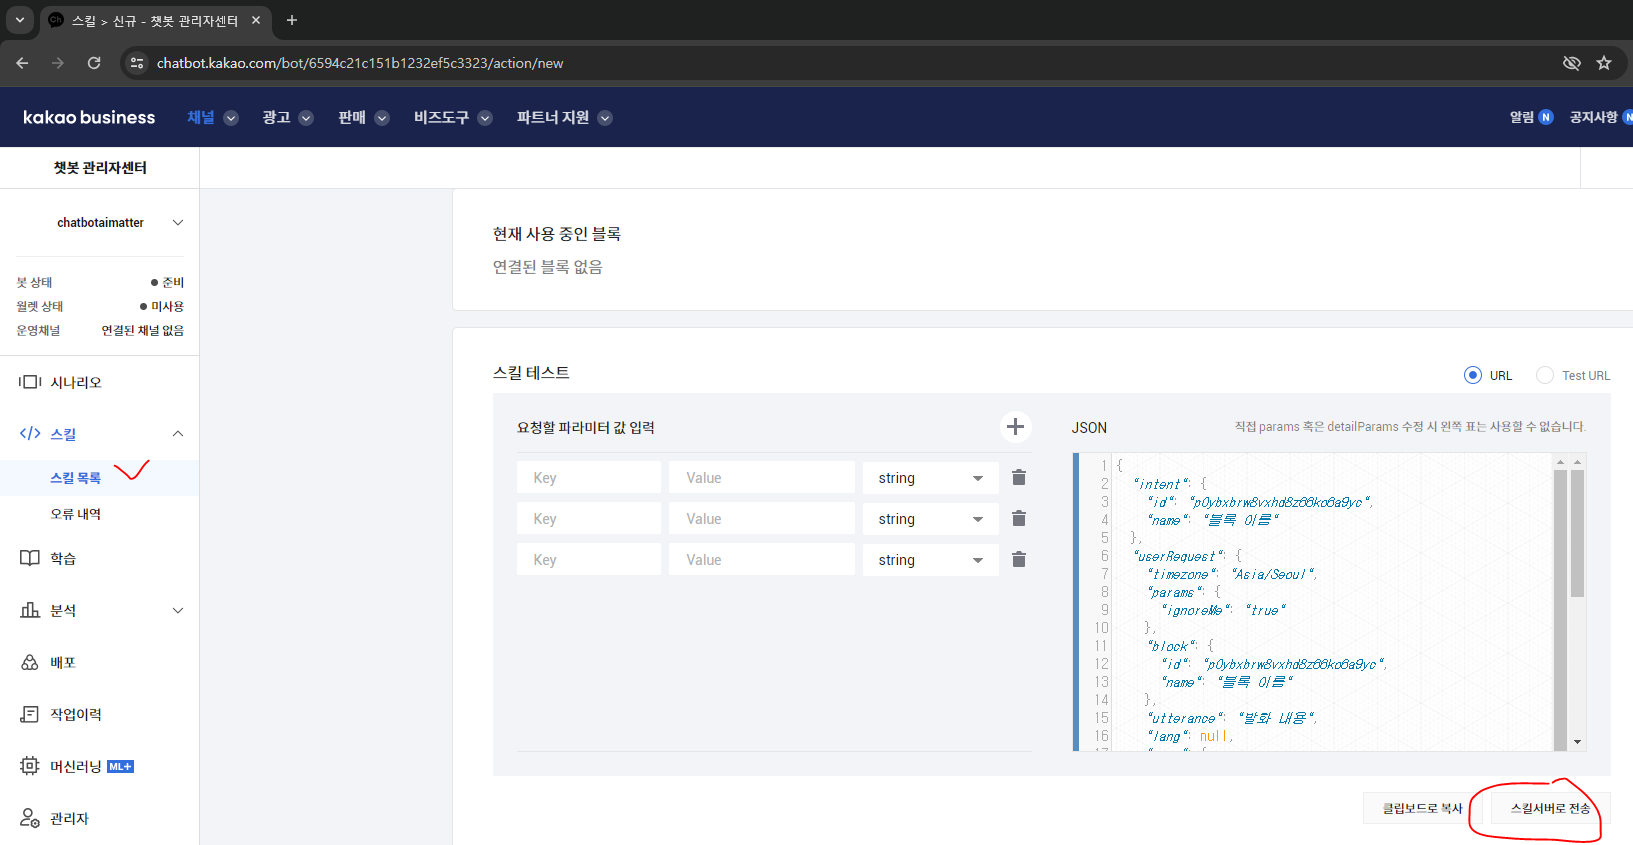

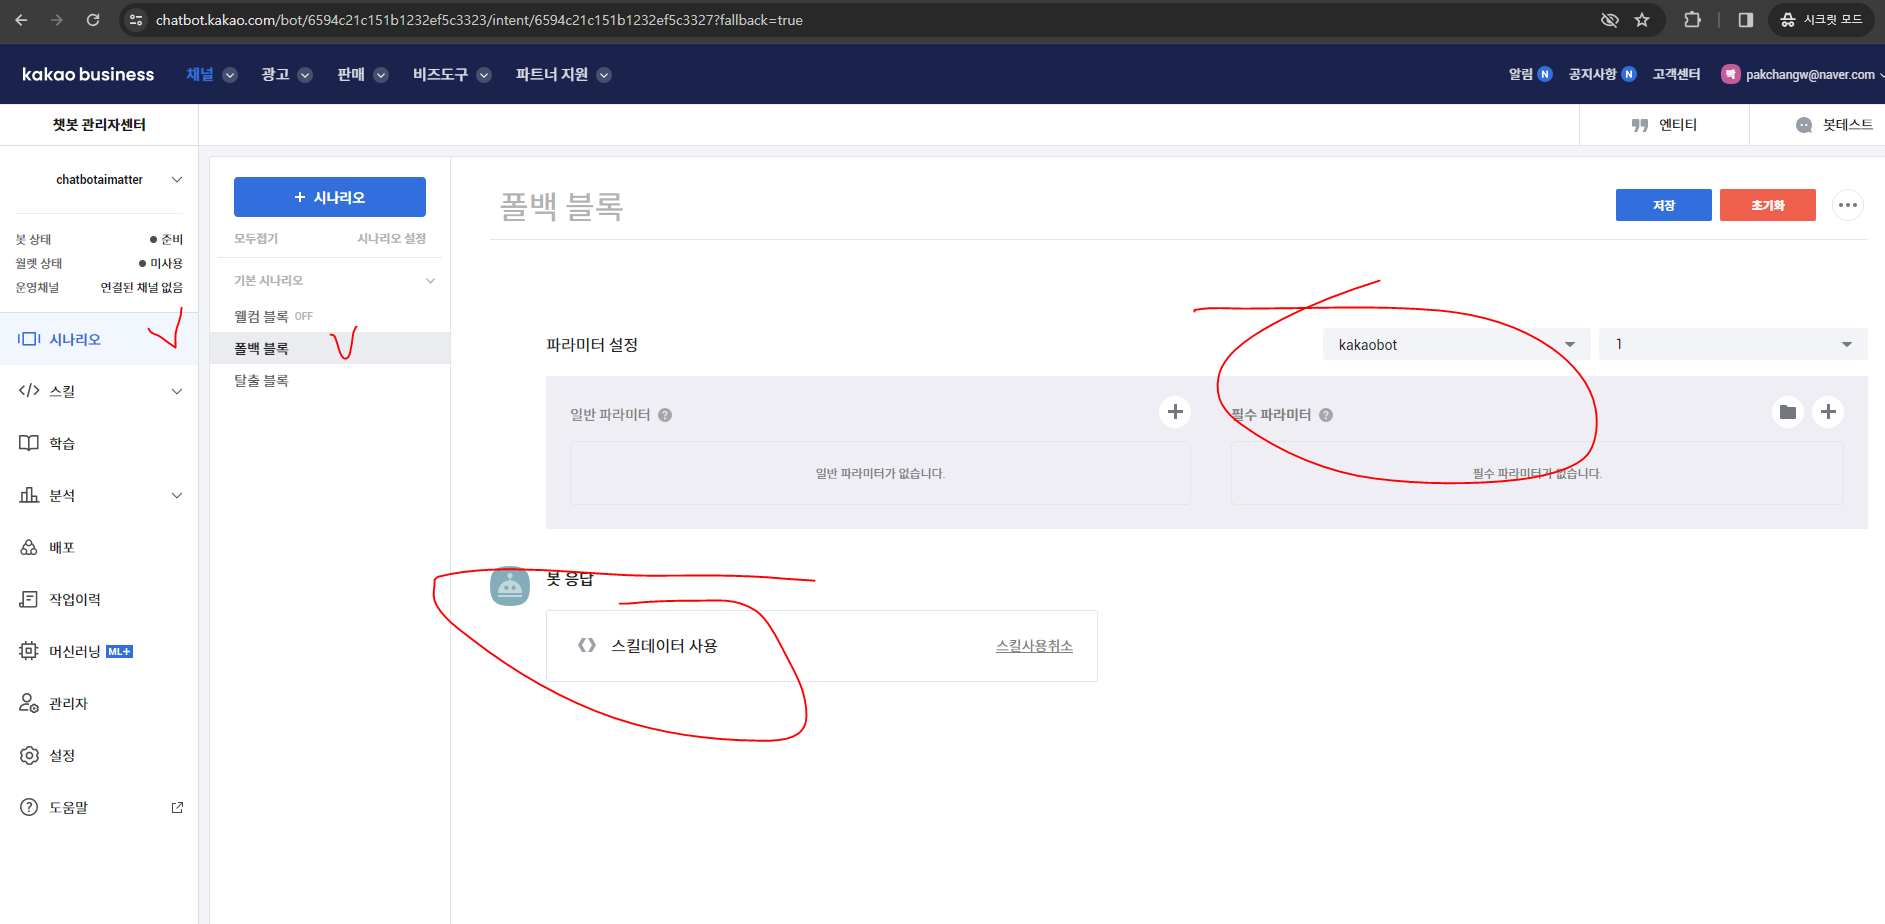

4. 기능구현

  1. 기본설정단계
    - 프로그램이 사용하는 패키지를 불러오고 OpenAPI의 API키를 지정한다.
  2.  기능 함수 구현 단계
    - 프로그램의 모든 기능을 함수화하여 메인 함수에서 사용할 수 있게 정리한다.
  3. 서버 생성단계
    - FastAPI를 활용하여 로컬 서버를 생성한다.
  4. 메인 함수 구현 단계
    - 프로그램을 구동하는 메인함수로 상황에 맞는 함수를 호출하여 코드를 진행한다.

In [7]:
%%writefile kakaobot.py

### 1. 기본 정보 설정 단계 ###
from fastapi import Request, FastAPI
import openai
import threading
import time
import queue as q
import os

API_KEY = 'sk-'
openai.api_key = API_KEY


### 2. 기능 함수 구현 단계 ###
# ChatGPT에게 질문/답변 받기
def getTextFromGPT(prompt):
  messages_prompt = [{'role' : 'system',
                      'content': 'You are a Thoughtful assistant. Respond to all input in 25 words and answer in Korean'}]
  messages_prompt += [{'role' : 'user',
                      'content': prompt}]
  response = openai.ChatCompletion.create(model = 'gpt-3.5-turbo', messages = messages_prompt)
  message = response['choices'][0]['message']['content']
  return message

# result = getTextFromGPT('빨강은 영어로?')
# print(result)

# 메세지 전송 : ChatGPT의 답변을 카카오톡 서버로 전달하기 위한 함수
def textResponseFormat(bot_response):
  response = {'version' : '2.0',
              'template' : {'outputs' : [{'simpleText' : {'text' : bot_response}}], 'quickReplies' : []}}
  return response

# 답변 요청 및 응답 확인 함수 : 사용자의 채팅을 분석하여 ChatGPT에게 답변한다.
def responseOpenAI(request, response_queue, filename):
  response_message = getTextFromGPT(request)
  print(response_message)


### 3. 서버 생성 단계 ###
app = FastAPI()

@app.get("/")
async def root():
  return {"message" : "KakaoTest"}

@app.post('/chat/')
async def chat(request : Request):
  kakaorequest = await request.json()
  print(kakaorequest)
  return mainChat(kakaorequest)


### 4. 메인 함수 단계 ###
# 메인함수
def mainChat(kakaorequest):
  run_flag = False
  start_time = time.time()

  # 응답 결과를 저장하기 위한 텍스트 파일 생성
  cwd = os.getcwd()
  filename = cwd + '/botlog.txt'
  if not os.path.exists(filename):
    with open(filename, 'w') as f:
      f.write('')
  else:
    print('File Exists')

  # 답변 생성 함수 실행
  response_queue = q.Queue()
  request_response = threading.Thread(target = responseOpenAI, args = (kakaorequest, response_queue, filename))
  request_response.start()






Overwriting kakaobot.py


---
---
---

# 강사님 코드 전체

'/img 가을 따뜻한 언덕' 이라고 입력시 이미지 출력  
'/ask 질문입력'

In [9]:
%%writefile kakaobot_T.py
###### 기본 정보 설정 단계 #######
from fastapi import Request, FastAPI
import openai
import threading
import time
import queue as q
import os

# OpenAI API KEY
API_KEY = 'sk-'
openai.api_key = API_KEY

###### 기능 구현 단계 #######

# 메세지 전송
def textResponseFormat(bot_response):
    response = {'version': '2.0', 'template': {
    'outputs': [{"simpleText": {"text": bot_response}}], 'quickReplies': []}}
    return response

# 사진 전송
def imageResponseFormat(bot_response,prompt):
    output_text = prompt+"내용에 관한 이미지 입니다"
    response = {'version': '2.0', 'template': {
    'outputs': [{"simpleImage": {"imageUrl": bot_response,"altText":output_text}}], 'quickReplies': []}}
    return response

# 응답 초과시 답변
def timeover():
    response = {"version":"2.0","template":{
      "outputs":[
         {
            "simpleText":{
               "text":"아직 제가 생각이 끝나지 않았어요🙏🙏\n잠시후 아래 말풍선을 눌러주세요👆"
            }
         }
      ],
      "quickReplies":[
         {
            "action":"message",
            "label":"생각 다 끝났나요?🙋",
            "messageText":"생각 다 끝났나요?"
         }]}}
    return response

# ChatGPT에게 질문/답변 받기
def getTextFromGPT(prompt):
    messages_prompt = [{"role": "system", "content": 'You are a thoughtful assistant. Respond to all input in 25 words'}]
    messages_prompt += [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages_prompt)
    message = response["choices"][0]["message"]["content"]
    return message

# DALLE.2에게 질문/그림 URL 받기
def getImageURLFromDALLE(prompt):
    response = openai.Image.create(prompt=prompt,n=1,size="512x512")
    print('image response:', response)
    image_url = response['data'][0]['url']
    return image_url

# 텍스트파일 초기화
def dbReset(filename):
    with open(filename, 'w') as f:
        f.write("")

###### 서버 생성 단계 #######
app = FastAPI()

@app.get("/")
async def root():
    return {"message": "kakaoTest"}

@app.post("/chat/")
async def chat(request: Request):
    kakaorequest = await request.json()
    print('kakaorequest:', kakaorequest)
    return mainChat(kakaorequest)

###### 메인 함수 단계 #######

# 메인 함수
def mainChat(kakaorequest):

    run_flag = False
    start_time = time.time()

    # 응답 결과를 저장하기 위한 텍스트 파일 생성
    cwd = os.getcwd()
    filename = cwd + '/botlog.txt'
    if not os.path.exists(filename):
        with open(filename, "w") as f:
            f.write("")
    else:
        print("File Exists")

    # 답변 생성 함수 실행
    response_queue = q.Queue()
    request_respond = threading.Thread(target=responseOpenAI,
                                        args=(kakaorequest, response_queue,filename))
    request_respond.start()

    # 답변 생성 시간 체크
    while (time.time() - start_time < 3.5):
        if not response_queue.empty():
            # 3.5초 안에 답변이 완성되면 바로 값 리턴
            response = response_queue.get()
            run_flag= True
            break
        # 안정적인 구동을 위한 딜레이 타임 설정
        time.sleep(0.01)

    # 3.5초 내 답변이 생성되지 않을 경우
    if run_flag== False:
        response = timeover()

    return response

# 답변/사진 요청 및 응답 확인 함수
def responseOpenAI(request,response_queue,filename):
    # 사용자다 버튼을 클릭하여 답변 완성 여부를 다시 봤을 시
    if '생각 다 끝났나요?' in request["userRequest"]["utterance"]:
        # 텍스트 파일 열기
        with open(filename) as f:
            last_update = f.read()
        # 텍스트 파일 내 저장된 정보가 있을 경우
        if len(last_update.split())>1:
            kind = last_update.split()[0]
            if kind == "img":
                bot_res, prompt = last_update.split()[1],last_update.split()[2]
                response_queue.put(imageResponseFormat(bot_res,prompt))
            else:
                bot_res = last_update[4:]
                response_queue.put(textResponseFormat(bot_res))
            dbReset(filename)

    # 이미지 생성을 요청한 경우
    elif '/img' in request["userRequest"]["utterance"]:
        dbReset(filename)
        prompt = request["userRequest"]["utterance"].replace("/img", "")
        bot_res = getImageURLFromDALLE(prompt)
        response_queue.put(imageResponseFormat(bot_res,prompt))
        save_log = "img"+ " " + str(bot_res) + " " + str(prompt)
        with open(filename, 'w') as f:
            f.write(save_log)

    # ChatGPT 답변을 요청한 경우
    elif '/ask' in request["userRequest"]["utterance"]:
        dbReset(filename)
        prompt = request["userRequest"]["utterance"].replace("/ask", "")
        bot_res = getTextFromGPT(prompt)
        response_queue.put(textResponseFormat(bot_res))

        save_log = "ask"+ " " + str(bot_res)
        print('save_log:', save_log)
        with open(filename, 'w') as f:
            f.write(save_log)

    #아무 답변 요청이 없는 채팅일 경우
    else:
        # 기본 response 값
        base_response = {'version': '2.0', 'template': {'outputs': [], 'quickReplies': []}}
        response_queue.put(base_response)

Writing kakaobot_T.py


In [ ]:
# Ngrok은 외부(Public)에서 로컬에 접속 할 수 있게 도와주는 터널링 프로그램이다.
from pyngrok import ngrok

port = 8000
ngrok.set_auth_token('')
print(dir(ngrok.connect(port)))
public_url = ngrok.connect(port).public_url
print('click', public_url)

# !uvicorn /content/drive/MyDrive/ai_chatbot_python/ChatGPT/005/kakaobot:app --reload --server.port=800  # --server.port=8000는 붙여서 적어야함
!uvicorn kakaobot_T:app --reload

# 계속 돌아가는 상태에서 진행

- 구름IDE  
https://goorm.io/dashboard
  - 컨테이너 만들기
  - 파이썬 컨테이너 만들기
  - 터미널에 pip 인스톨하기
  ```
    pip install fastapi
    pip install 'uvicorn[standard]'
    pip install openai==0.28.1
  ```

  - 코드넣기
  ```
    from fastapi import Request, FastAPI
    import openai
    import threading
    import time
    import queue as q
    import os

    API_KEY = 'sk-'
    openai.api_key = API_KEY

    def textResponseFormat(bot_response):response = {'version': '2.0', 'template': {'outputs': [{"simpleText":{"text":bot_response}}], 'quickReplies': []}}
        return response

    def imageResponseFormat(bot_response,prompt):
        output_text = prompt+"내용에 관한 이미지 입니다"
        response = {'version': '2.0', 'template': {
        'outputs': [{"simpleImage": {"imageUrl": bot_response,"altText":output_text}}], 'quickReplies': []}}
        return response

    def timeover():
        response = {"version":"2.0","template":{"outputs":[{"simpleText":{"text":"아직 제가 생각이 끝나지 않았어요🙏🙏\n잠시후 아래 말풍선을 눌러주세요👆"}}],"quickReplies":[{"action":"message","label":"생각 다 끝났나요?🙋","messageText":"생각 다 끝났나요?"}]}}
        return response

    def getTextFromGPT(prompt):
        messages_prompt = [{"role": "system", "content": 'You are a thoughtful assistant. Respond to all input in 25 words'}]
        messages_prompt += [{"role": "user", "content": prompt}]
        response = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages_prompt)
        message = response["choices"][0]["message"]["content"]
        return message

    def getImageURLFromDALLE(prompt):
        response = openai.Image.create(prompt=prompt,n=1,size="512x512")
        print('image response:', response)
        image_url = response['data'][0]['url']
        return image_url

    def dbReset(filename):
        with open(filename, 'w') as f:
            f.write("")

    app = FastAPI()

    @app.get("/")
    async def root():
        return {"message": "kakaoTest"}

    @app.post("/chat/")
    async def chat(request: Request):
        kakaorequest = await request.json()
        print('kakaorequest:', kakaorequest)
        return mainChat(kakaorequest)

    def mainChat(kakaorequest):
        run_flag = False
        start_time = time.time()
        cwd = os.getcwd()
        filename = cwd + '/botlog.txt'
        if not os.path.exists(filename):
            with open(filename, "w") as f:
                f.write("")
        else:
            print("File Exists")    
        response_queue = q.Queue()
        request_respond = threading.Thread(target=responseOpenAI,args=(kakaorequest, response_queue,filename))
        request_respond.start()
        while (time.time() - start_time < 3.5):
            if not response_queue.empty():
                response = response_queue.get()
                run_flag= True
                break
            time.sleep(0.01)
        if run_flag== False:     
            response = timeover()
        return response

    def responseOpenAI(request,response_queue,filename):
        if '생각 다 끝났나요?' in request["userRequest"]["utterance"]:
            with open(filename) as f:
                last_update = f.read()
            if len(last_update.split())>1:
                kind = last_update.split()[0]  
                if kind == "img":
                    bot_res, prompt = last_update.split()[1],last_update.split()[2]
                    response_queue.put(imageResponseFormat(bot_res,prompt))
                else:
                    bot_res = last_update[4:]
                    response_queue.put(textResponseFormat(bot_res))
                dbReset(filename)
        elif '/img' in request["userRequest"]["utterance"]:
            dbReset(filename)
            prompt = request["userRequest"]["utterance"].replace("/img", "")
            bot_res = getImageURLFromDALLE(prompt)
            response_queue.put(imageResponseFormat(bot_res,prompt))
            save_log = "img"+ " " + str(bot_res) + " " + str(prompt)
            with open(filename, 'w') as f:
                f.write(save_log)
        elif '/ask' in request["userRequest"]["utterance"]:
            dbReset(filename)
            prompt = request["userRequest"]["utterance"].replace("/ask", "")
            bot_res = getTextFromGPT(prompt)
            response_queue.put(textResponseFormat(bot_res))
            save_log = "ask"+ " " + str(bot_res)
            print('save_log:', save_log)
            with open(filename, 'w') as f:
                f.write(save_log)
        else:
            base_response = {'version': '2.0', 'template': {'outputs': [], 'quickReplies': []}}
            response_queue.put(base_response)
  ```

  - 컨테이너 url복사 후 카카오톡에 업데이트하기

  - 터미널에 아래 코드 입력
  ```
    uvicorn 파일이름:app --reload --host=0.0.0.0 --port=80
  ```